In [1]:
import numpy as np
from scipy.ndimage import convolve
from tqdm import tqdm_notebook as tqdm
from PIL import Image

from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Div
from bokeh.layouts import row

from  ipywidgets import interact
output_notebook()

Loading BokehJS ...

### Few words on setting up (partial) differential equations

Physical systems are traditionally described by balance-equations, which reflect conservation of some property of a system: at any point in time all the stuff that goes into the box must go out of the box, it doesn't spontaneously emerge or disappear into the void. Simple. 

_Ok, what if it doesn't disappear, but is just converted into "other stuff" in some sort of reaction?_ 

Fine, at any point in time all the stuff that goes into the box must balance out the stuff that goes out of the box and reacts away inside the box (also, for general accounting purposes, we should write a similar balance for the "other stuff" which is now generated inside the box). 

_Ok ok, but what if the box has a capacity to build up and release some reserve of stuff?_ 

Fine! Any stuff that comes in and is not balanced out by going out and reacting away is accumulated inside the box!

<img src="images/setting_up_the_balance.png" style="width:770px;height:270px;"></img>

_Better. But what's this! Concentration of stuff is the same everywhere in the box? This might be acceptable to describe a chemical reaction in a well-stirred beaker, but what about all those nonhomogenous systems?_ 

Easy. We'll just pretend that our box is composed of several smaller compartments connected in series. Concentration of stuff inside each compartment can be homogenous, but, as long as the number of such compartments is sufficiently high, this __tanks-is-series__ model should approximate the original system well. Ideally we'd want to approximate our system by the series of infinitely many infinitesimal compartments. Such system would be described by a __partial differential equation (PDE)__, in which concentration $c$ would depend both on time $t$ and coordinate $x$. Of course for practical purposes we'll __discretize__ the system into finite number of compartments and treat the concentration in each compartment $c_{i}$ as an individual variable which depends only on time $t$:   

<img src="images/setting_up_the_pfr_balance_hor.png" style="width:850px;height:250px;"></img>

<i>Better, but still not perfect. Now all the stuff is always moving in the same direction - there's no back mixing... This model might be acceptable to describe the flow of water through long narrow pipes, but there's no way we can use it to describe the growth of bacteria in a petri dish where stuff diffuses in all directions.</i>

Ok, __diffusion__ is a bit trickier. Stuff, as expected, diffuses to locations where its concentration is lower. More specifically, diffusive [flux](https://en.wikipedia.org/wiki/Flux) is driven by a concentration gradient - change in concentration per unit of distance ($-\frac{dc}{dx}$) for those living in a 1D world, or per unit of space ($-\nabla{c}$) for everyone else ($\nabla$ is [nabla](https://en.wikipedia.org/wiki/Nabla_symbol) operator; negative sign indicates that the flux is _positive_ in the direction along which the concentration _decreases_). If we choose $D$ to be some proportionality constant characteristic for our stuff and environment through which it diffuses, then we can write the expression for the diffusive flux as:

$$ J = -D \frac{dc}{dx} \text{   or   } J = -D \nabla{c}$$

Flux tells us something about the __direction__ of diffusion but doesn't tell anything about its __rate__. To get the expression for the rate of concentration change at any point in space we can speculate that if there is no chemical reaction, the change of concentration can only be due to flux from neighbouring compartments. So $ \frac{\partial c}{\partial t} + \frac{\partial J}{\partial x} = 0$. If we combine it with the expression for flux, we'll get the proper expression for the diffusion rate, also known as [second Fick's law](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion) of diffusion:

$$ \frac{\partial c}{\partial t} = D\frac{\partial^2 c}{\partial x^2} \text{   or   } \frac{\partial c}{\partial t} = D\nabla^2{c}$$


The only thing left to do now is to figure out how we can adjust this expression to account for reaction. Well, if there _is_ a reaction, then the change of concentration of stuff at any point in space can be explained both by its diffusion from one compartment to another _and_ by its reaction to "another stuff" within the same compartment. So we can just _add_ the reaction term to the Fick's law taking care of the units:

<img width="700" height="550" src="images/reaction-diffusion.png"></img>

Remember, that in 1D second order derivative is just a "gradient of a gradient", so in discretized form we can write it as $\big(\frac{\Delta c_{i+1}}{\Delta x} - \frac{\Delta c_{i}}{\Delta x}\big)/\Delta x$. This 1D discretization  nicely shows, how diffusion term mathematically "smoothens" the concentration values over the neighbouring compartments by [convolving](https://en.wikipedia.org/wiki/Convolution) the concentrations with  $\begin{bmatrix} 1 & -2 & 1 \end{bmatrix}$ kernel.

<img width="600" height="80" src="images/fick_discretization.png"></img>

> <font size=2> Okay! Lat's be clear about it: operation of sliding a kernel (in our case $\begin{bmatrix}1 & -2 & 1 \end{bmatrix}$) over a function (in our case concentration map) and on each stride taking a sum of the element-wise product between kernel and function, should be called [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation), not [convolution](https://en.wikipedia.org/wiki/Convolution). In case of convolution kernel needs to be additionally "flipped". However, since our kernel is symmetrical, this "flipping" (or the lack of it) has no effect on the outcome. So convolving the concentration map with $\begin{bmatrix}1 & -2 & 1 \end{bmatrix}$-kernel yields the same result as cross-correlating the two. Here I intentionally used the term "convolution", because it was conveniently popularized through [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), so most people would likely be more familiar with it. </font>

2D extension of the discretized term also becomes quite intuitive once it's visualized. This time we're convolving/cross-correlating with $\begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}$-kernel:

<img width="700" height="400" src="images/fick_discretization_2d.png"></img>

You might imagine that this effect can be quite handy for blurring out the noise in the images. And indeed, the exact same diffusion equation (although usually referred to as "heat equation") is used in image processing as a simple blurring tool. You just need to treat the RGB channels of an image as 2D concentration maps of some chemical species. Let's work out this example!



### Adding diffusion to image

Suppose we want to test the effect of diffusion on an image:

<img height="300" width="300" src="images/Shoggoth_by_pahko.jpg"></img>
<body><center><font size="2">A Shoggoth. <a href="https://commons.wikimedia.org/wiki/File:Shoggoth_by_pahko.jpg">Artwork</a> by <a href="https://www.deviantart.com/pahkomoreno">PahkoMoreno</a> inspired by H .P. Lovecraft's short novel "At the Mountains of Madness".</font></center></body>

Let's resize it a bit to speed up the processing.

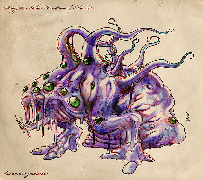

In [11]:
img = Image.open('images/Shoggoth_by_pahko.jpg')
img = img.resize(size=(203,180))
img_mtx = np.array(img)

img

Looks a bit less fabulous, but it will do. 

In [3]:
print(img_mtx.shape) # confirm the new image size

(180, 203, 3)


Let's start with writing a function which would calculate the change of RBG "concentration" in each pixel. Remember that the pixels at the edges (on the boundary) are different from the rest: there is no diffusive flux comming from the outside the image, so we should somehow reflect it in the code. One way of doing it involves padding the 2D concentration map with the "nearest" edge values. Since diffusive flux is driven by concentration difference, having the same values on both sides of the boundary would fulfill the "no flux over the boundary" condition. 

<img width="500" height="400" src="images/boundary_condition.png"></img>

In [4]:
def balances(_, x, p):
    """returns the accumulation terms dxdt for each pixel and each color channel
    INPUT:
        t:float:    current time-instance
        x:1D array: flattened vector of state variables ("concentrations")
        p:dict:     parameters
    OUTPUT:
        dxdt: 1D array, same size as x: flat vector of accumulation terms 
    """
    x = x.reshape(p['size'])   # resize flat 1D array back into (height,width,#channels)-array
    reaction  = np.zeros(p['size']) # preallocate the reaction term
    diffusion = np.zeros(p['size']) # preallocate the diffusion term
    
    # --- get diffusion term --- 
    laplacian = np.array([[0,  1, 0], 
                          [1, -4, 1], 
                          [0,  1, 0]])       
    for k in range(p['size'][2]):  
        # pad the concentration array with values "nearest" to the edge
        # to comply with "no flux through the boundary" condition
        diffusion[:,:,k] = p['D'][k]/p['h']**2 * convolve(x[:,:,k], laplacian, mode="nearest")
            
    # ---get total accumulation term---
    dxdt = diffusion
                
    return dxdt.ravel() 

><font size=2>Notice that we switched to [state-space](https://en.wikipedia.org/wiki/State-space_representation) notation:  we now use $\textbf{x} = [x_1, x_2, x_3]^T$ to denote the set of [state variables](https://en.wikipedia.org/wiki/State_variable) - variables that describe the state of a system at any point in time. In our case state variables are just "concentrations" of red, green and blue colors in each pixel</font>

This function calculates the $\frac{dx}{dt}$ term for a single time step. So to find how RGB "concentrations" change over time, we'd need to repeat the same calculation for different time instances. We'll do it using [Euler Forward method](https://en.wikipedia.org/wiki/Euler_method).

><font size=2>Quick recap: [numerical solutions of ordinary differential equations](recaps/numerical_solutions_recap.ipynb)</font>

In [5]:
def euler_forward(dxdt, x, t_span, p):
    """returns the values of x at time instances given in t_span 
    calculated using function dxdt with parameters p
    INPUT:
        dxdt: function object: function that returns dxdt as flat 1D ndarray
        x: 1D array:           initial condition
        t_span: 1D array:      time instances
        p: dict:               parameters used by dxdt
    OUTPUT:
        x_span: (len(x), len(t_span)) array"""
    x = x.astype('float')
    x_span = np.zeros((len(x), len(t_span)))
    x_span[:,0] = x
    
    for it,t in enumerate(tqdm(t_span[1:])): # we already know x at t=0
        
        dt = t_span[it+1] - t_span[it]
        x += dxdt(t, x, p)*dt
        x_span[:,it+1] = x
                
    return x_span 

In [6]:
# run the simulation
# specify time, initial condition and parameters
t0, tf, dt = 0, 50, 0.5
t_span = np.arange(t0,tf+dt,dt)
x0 = img_mtx.ravel()/255    # we'll use the image as initial condition! (flattened and rescaled)
p = {'size': img_mtx.shape, # dimensions of image array
     'h': 1,                # spatial step-size (in our case it's just 1 px)
     'D': [0.04, 0.02, 0.06]}# diffusion constants for RGB channels

# run the simulation: use Euler Forward to find the RGB "concentrations" numerically
img_development = euler_forward(balances, x0, t_span, p)

print(f"shape: {img_development.shape}\nmin: {img_development.min()}\nmax: {img_development.max()}")



shape: (109620, 101)
min: 0.0
max: 1.0


### Interpreting image as... image

Great, we just calculated different frames of an animation with gradually blurring image! Only these frames are stored as flat columns in `img_development` array, so we'd need to reshape them first. Also, for now the values of this array range form $0$ to $1$, so we can easily convert them back to 256 colors (if we use 8 bit color scheme). However, later on we will modify the code, so that the colors would not only diffuse, but also react among each other. As a result, the values of `img_development` would vary in somewhat arbitrary range, so we'd first need to squeeze them back to $(0,1)$ interval. Of course we can just clip everything below $0$ and above $1$, but that's a bit boring... and abrupt. Alternatively we can use [logistic](https://en.wikipedia.org/wiki/Logistic_function) function to smoothly squishify everything to $(0,1)$ interval using nonlinear trasnformation:

<img height="300" width="400" src="images/logistic_function.png"></img> 

where $k$ is the steepness of the curve and $x_0$ is the x-value of its midpoint. Can you see how changing $k$ or $x_0$ would affect the image? Run the code and check if you're right.

In [7]:
def convert2img(x, size, steepness=5.5, midpoint=0.5):
    """transforms 1D array x into an image of given size
    INPUTS:
        x: 1D array [float]: flat array containing color info for each pixel
        size: (height, width, #channels) [int]: size of the image
        steepness: float: steepness of logistic function at midpoint (used for transforming x)
        midpoint: float: midpoint of logistic function (used for transforming x)
    OUTPUTS:
        (height, width, 4) array of ints ranging from 0 to 255 
        (first 3 depth layers are the RGB channels, and the last layer is the transparency layer)
        """        
    # reshape
    x = x.reshape(size)
    
    # rescale into (0,1) floats
    x = 1/(1 + np.exp(-steepness*(x-midpoint)))        
    
    # rescale into (0,255) ints
    x *= 255
    x = x.astype(np.uint8)
    
    # if x has less than 3 depth layers:
    if size[2] < 3:
        # add dummy channels filled with 255//2
        x = np.concatenate((x, 255//2 * np.ones((size[0], size[1], 3-size[2]), dtype=np.uint8)), axis=2)
            
    # if x has more than 4 depth layers - trim all layers after 4th
    # (first 3 layers would be interpreted as RGB channels and 4th layer - as transparency channel)
    if size[2] > 4:
        x = x[:,:,:3]    
    
    # if x has exactly 3 depth layers:
    if x.shape[2] == 3:
        # add transparency channel and set each val in this layer to 255 (no transparency)
        x = np.concatenate((x, 255*np.ones((size[0], size[1], 1), dtype=np.uint8)), axis=2)
        
    return  x

# plot stuff!
# (remember that individual frames are stored as columns of `img_development` array)
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development[:,0], p['size']))]})

pb = figure(x_range=(0,p['size'][1]), y_range=(0,p['size'][0]),
            plot_width=p['size'][1]*2, plot_height=p['size'][0]*2)
r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][1], dh=p['size'][0])
show(pb, notebook_handle=True)

# add a slider to check the effects of steepness and midpoint of logistic function
# and rediscover some common photoshop tools :)
def update_effects(steepness=5.5, midpoint=0.5):
    r.data_source.data['img'] = [np.flipud(convert2img(img_development[:,0], 
                                                       p['size'], steepness=steepness, midpoint=midpoint))]
    push_notebook()
    
interact(update_effects, steepness=(-10,10,0.1), midpoint=(-0.5,1,0.1))

interactive(children=(FloatSlider(value=5.5, description='steepness', max=10.0, min=-10.0), FloatSlider(value=…

<function __main__.update_effects(steepness=5.5, midpoint=0.5)>

Now, when we know how to convert the columns of `img_development` into an image, let's check how diffusion transforms this image over time (finally!).

In [8]:
# plot stuff!
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development[:,0], p['size']))]})

pb = figure(x_range=(0,p['size'][1]), y_range=(0,p['size'][0]),
            plot_width=p['size'][1]*2, plot_height=p['size'][0]*2)
r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][1], dh=p['size'][0])
show(pb, notebook_handle=True)

# add a slider to check the effect of diffusion over time
def update_frames(t=0):
    i = int(t/dt)
    r.data_source.data['img'] = [np.flipud(convert2img(img_development[:,i], p['size']))]
    push_notebook()
    
interact(update_frames, t=(t0,tf,dt))

interactive(children=(FloatSlider(value=0.0, description='t', max=50.0, step=0.5), Output()), _dom_classes=('w…

<function __main__.update_frames(t=0)>


Diffusion indeed creates the blurring effect - no surprises here...

### Adding reaction to image

Let's make things a bit more interesting and add a reaction! Suppose the red, green and blue color channels in our image "react" like species in [predator-prey](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) system (it's a classical example of an oscillating system, so it would be quite appropriate to use it in this notebook). 

Although, while original predator-prey system describes the interactions of two species (predator and prey), in our case we need to deal with three (red, green and blue colors). This means that we might need to adapt "rock-paper-scissors" type of interaction: red preys on green, green preys on blue, and blue preys on red. This might not seem very biological, but who'd be there to stop us from exploring :)

<img height="50" width="400" src="images\red2blue2green.png"></img>

To formalize this type of relation we need to realize that for one species to succesfully prey on another both species need to occasionally appear at the same place at the same time. In a very simple case the probability of such encounters would be proportional to "concentration" of each species scaled by some proportionality constant. The population of predators would grow as a result of such encounters, while the population of prey would diminish. For example, we can formalize the "red preys on green"-part of the system as:
$ \begin{cases} \frac{dx_{red,growth}}{dt} = k_{1}x_{red}x_{green}\\
                 \frac{dx_{green,decay}}{dt} = -k_{1}x_{red}x_{green} \end{cases}$.
Similarly, the "green preys on blue" and "blue preys on red" parts would be 
$ \begin{cases} \frac{dx_{green,growth}}{dt} = k_{2}x_{green}x_{blue}\\
                 \frac{dx_{blue,decay}}{dt} = -k_{2}x_{green}x_{blue} \end{cases}$ and 
$ \begin{cases} \frac{dx_{blue,growth}}{dt} = k_{3}x_{blue}x_{red}\\
                 \frac{dx_{red,decay}}{dt} = -k_{3}x_{blue}x_{red} \end{cases}$, respectively 
(with $k_i$ being some proportionality constants).
                 
So all-in-all we can write 
$ \begin{cases} \frac{dx_{red}}{dt} = k_{1}x_{red}x_{green} - k_{3}x_{blue}x_{red} \\
                \frac{dx_{green}}{dt} = k_{2}x_{green}x_{blue} - k_{1}x_{red}x_{green} \\
                \frac{dx_{blue}}{dt} = k_{3}x_{blue}x_{red} - k_{}x_{green}x_{blue} \end{cases}$.
These are the reactions occuring in each pixel. For the whole image we'll need to consider the spatial dimensions and add diffusion:


In [9]:
def balances(_, x, p):
    """returns the accumulation terms dxdt for each pixel and each color channel
    INPUT:
        t:float:    current time-instance
        x:1D array: flattened vector of state variables ("concentrations")
        p:dict:     parameters
    OUTPUT:
        dxdt: 1D array, same size as x: flat vector of accumulation terms 
    """
    x = x.reshape(p['size'])   # resize flat 1D array back into (height,width,#channels)-array
    reaction  = np.zeros(p['size']) # preallocate the reaction term
    diffusion = np.zeros(p['size']) # preallocate the diffusion term
    
    # --- get diffusion term ---   
    laplacian = np.array([[0,  1, 0], 
                          [1, -4, 1], 
                          [0,  1, 0]])       
    for k in range(p['size'][2]):             
        diffusion[:,:,k] = p['D'][k]/p['h']**2 * convolve(x[:,:,k], laplacian, mode="nearest")
        
    # --- get reaction term ---
    # we can use any random reactions for this example, so feel free to change the terms/parameters.
    # the default reactions below can be interpreted as something like:
    # red "preys" on "green" preys on "blue" preys on "red"
    reaction[:,:,0] = p['k1']*x[:,:,0]*x[:,:,1] - p['k3']*x[:,:,2]*x[:,:,0]
    reaction[:,:,1] = p['k2']*x[:,:,1]*x[:,:,2] - p['k1']*x[:,:,0]*x[:,:,1]
    reaction[:,:,2] = p['k3']*x[:,:,2]*x[:,:,0] - p['k2']*x[:,:,1]*x[:,:,2]
    
    # --- get total accumulation term---
    dxdt = diffusion + reaction
                
    return dxdt.ravel() 


# specify time, initial condition and parameters
t0, tf, dt = 0, 185, 0.5
t_span = np.arange(t0,tf+dt,dt)
x0 = img_mtx.ravel()/255     # we'll use the image as initial condition! (flattened and rescaled)
p = {'size': img_mtx.shape,  # image size
     'h': 1,                 # spatial step-size (we can just use 1 px)
     'D': [0.02, 0.01, 0.03],# diffusion constants for RGB channels
     'k1': 0.10,             # some reaction coefficients (feel free to change)
     'k2': 0.15,
     'k3': 0.20}

# run the simulation: use Euler Forward to find the RGB "concentrations" numerically
img_development = euler_forward(balances, x0, t_span, p)

# plot stuff!
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development.T[0], p['size']))]})
show(pb, notebook_handle=True)    
interact(update_frames, t=(t0,tf,dt))

interactive(children=(FloatSlider(value=0.0, description='t', max=185.0, step=0.5), Output()), _dom_classes=('…

<function __main__.update_frames(t=0)>

If everything works well you should see a succession: red > blue > green > red > blue...

### Organizing the reaction term

As a final touch, we'll bring some order to the reaction term, and we'll do it by decoupling reaction [stoichiometry](https://en.wikipedia.org/wiki/Stoichiometry) from reaction [kinetics](https://en.wikipedia.org/wiki/Chemical_kinetics). In short, stoichiometry reflects the quantitative relations between the reacting species, whereas kinetics captures the reaction rates.

><font size=2> For example, the main constituent of the bone mineral, hydroxyapatite $Ca_{10}(PO_4)_6(OH)_2$, can be synthesized in the lab by making $Ca(OH)_2$ react with $H_3PO_4$ according to
>    $$ 10Ca(OH)_2 + 6H_3PO_4 \rightarrow Ca_{10}(PO_4)_6(OH)_2 + 18H_2O $$
> Stoichiometry tells us that to get one molecule of hydroxyapatite we need 10 molecules of $Ca(OH)_2$ and 6 molecules of $H_3PO_4$, or, in other words, stoichiometric coefficients of $Ca_{10}(PO_4)_6(OH)_2$, $Ca(OH)_2$ and $H_3PO_4$ are $1$, $-10$ and $-6$, respectively (the latter two are consumed in the reaction, hence the negative signs). And kinetics tells us that the rate of this reaction can be something like $k[Ca(OH)_2]^{n}[H_3PO_4]^{m}$, where $[X]$ is concentration of species $X$, $k$ is some rate constant, and $n$ and $m$ are some numbers. If no intermediate compounds are produced/consumed during this reaction, we should have $n=10$ and $m=6$, reflecting that hydroxyapatite synthesis rate should be proportional to probability of encountering $10$ molecules of $Ca(OH)_2$ and $6$ molecules of $H_3PO_4$ at the same time and place.    
</font>

When we have a complex system with multiple species reacting and multiple processes taking place it becomes more convenient to store all the stoichiometric relations between species in a form of a matrix. In biochemistry literature rows of the matrix correspond to reacting species and columns correspond to independent processes. And in wastewater treatment literature it's the other way around: rows correspond to processes and columns - to species. We'll use the latter, although it's just a matter of convention.

In our example the reacting species are red, green and blue colors; and the independent processes are the growth of red, growth of green, and growth of blue (growth of red and consumption of green are the two sides of the same process, so - not independent). Then, the elements of the stoichiometric matrix can be arranged as following: 

<img height="300" width="700" src="images\reaction_vectorization.png"></img>

The first row of the matrix says that during the growth of red one unit of red is produced and one unit of green is consumed; while the first column says that red is produced during its growth and consumed during the growth of blue. Kinetic rates of these process are stored in $\textbf{r}$. Therefore, the net growth of each species $j$ can be found simpy by multiplying each element of the column $\textbf{S}_j$ by the corresponding element of $\textbf{r}$ and summing up the results (in other words - by taking a [dot product](https://en.wikipedia.org/wiki/Dot_product) between $\textbf{S}_j$ and $\textbf{r}$). 

This matrix notation is pretty useful for doing sanity checks on system logic and for automating the calculation of the reaction term. Both of these features are quite important when working with large complex systems. Our sample system is neigher large, nor complex, but let's use matrix notation anyway, just for a sake of good practice.
 

In [10]:
def balances(t, x, p):
    """returns the accumulation terms dxdt for each pixel and each color channel
    INPUT:
        t:float:    current time-instance
        x:1D array: flattened vector of state variables ("concentrations") at time t
        p:dict:     parameters
    OUTPUT:
        dxdt: 1D array, same size as x: flat vector of accumulation terms 
    """
    x = x.reshape(p['size'])        # resize flat 1D array back into (height,width,#channels)-array   
    reaction  = np.zeros(p['size']) # preallocate the reaction term
    diffusion = np.zeros(p['size']) # preallocate the diffusion term
        
    # process rates: the only part of the code which needs customization
    rates = np.stack((p['k1']*x[:,:,0]*x[:,:,1], # growth of red
                      p['k2']*x[:,:,1]*x[:,:,2], # growth of green
                      p['k3']*x[:,:,2]*x[:,:,0]),# growth of blue 
                      axis=2) # rates.shape = (height, width, #processes)
    
    laplacian = np.array([[0,  1, 0], 
                          [1, -4, 1], 
                          [0,  1, 0]])   
    
    for k in range(p['size'][2]):
        # --- get diffusion term ---
        diffusion[:,:,k] = p['D'][k]/p['h']**2 * convolve(x[:,:,k], laplacian, mode="nearest")
        
        # --- get reaction term ---
        reaction[:,:,k] = np.sum(p['S'][:,k].reshape(1,1,-1)*rates, axis=2)
        
    # --- get total accumulation term ---
    dxdt = diffusion + reaction
        
    return dxdt.ravel()

# specify time, initial condition and parameters
t0, tf, dt = 0, 185, 0.5
t_span = np.arange(t0,tf+dt,dt)
x0 = img_mtx.ravel()/255
# stoichiometric mtx:R   G   B
p['S'] = np.array([[ 1, -1,  0],  # growth of red
                   [ 0,  1, -1],  # growth of green
                   [-1,  0,  1]]) # growth of blue

# run the simulation: use Euler Forward to find the RGB "concentrations" numerically
img_development = euler_forward(balances, x0, t_span, p)

# plot stuff!
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development[:,0], p['size']))]})
show(pb, notebook_handle=True)    
interact(update_frames, t=(t0,tf,dt))

interactive(children=(FloatSlider(value=0.0, description='t', max=185.0, step=0.5), Output()), _dom_classes=('…

<function __main__.update_frames(t=0)>

### Not bad, but I was promised patterns! I want examples with pattern formation!

Sure, try these:
- [Stripy patterns of marine angelfish](examples/angelfish.ipynb)
- [Spots and stripes in predator-prey system](examples/predator_prey.ipynb)
- [Cells, corals and spirals in Gray-Scott system](examples/gray-scott.ipynb)

